In [1]:
import fsrs_optimizer

timezone = "Europe/Moscow"
next_day_starts_at = 5
revlog_start_date = "2006-10-05"  # YYYY-MM-DD
filter_out_suspended_cards = False
filter_out_flags = []

optimizer = fsrs_optimizer.Optimizer()
optimizer.anki_extract(
    "./Main_27.04.2023.apkg", filter_out_suspended_cards, filter_out_flags
)
optimizer.create_time_series(
    timezone, revlog_start_date, next_day_starts_at, analysis=False
)
optimizer.define_model()
optimizer.pretrain(verbose=False)

Deck file extracted successfully!
revlog.csv saved.


  0%|          | 0/30507 [00:00<?, ?it/s]

Trainset saved.
Pretrain finished!


[]

In [2]:
from torch import Tensor, nn
import torch
from statsmodels.nonparametric.smoothers_lowess import lowess


class ICILoss(nn.Module):
    def __init__(self):
        super(ICILoss, self).__init__()
        self.loss_fn = nn.L1Loss(reduce="None")

    def forward(self, predictions: Tensor, labels: Tensor) -> Tensor:
        observation = lowess(
            labels.detach().numpy(),
            predictions.detach().numpy(),
            it=0,
            delta=0.01
            * (max(predictions.detach().numpy()) - min(predictions.detach().numpy())),
            return_sorted=False,
        )
        observation = torch.as_tensor(observation, dtype=torch.float32)
        return self.loss_fn(predictions, observation)

  0%|          | 0/248083 [00:00<?, ?it/s]

dataset built


train:   0%|          | 0/1756144 [00:00<?, ?it/s]

iteration: 175295
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1054, 1.131, 0.825, 0.0436, 1.6274, 0.1373, 1.0029, 2.1301, 0.0859, 0.3183, 1.3531, 0.2169, 2.7849]
iteration: 349757
w: [0.3474, 0.3474, 1.592, 90.5314, 5.106, 1.1315, 0.827, 0.0409, 1.6263, 0.1394, 1.0018, 2.1285, 0.0876, 0.3166, 1.3519, 0.2154, 2.7859]
iteration: 525052
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1066, 1.1319, 0.8285, 0.0385, 1.6253, 0.1412, 1.0008, 2.127, 0.0893, 0.315, 1.3508, 0.214, 2.7867]
iteration: 699514
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1068, 1.132, 0.8296, 0.0369, 1.6247, 0.1424, 1.0003, 2.1262, 0.0902, 0.314, 1.3503, 0.2132, 2.7873]
iteration: 874809
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1068, 1.1317, 0.8303, 0.0356, 1.6244, 0.1433, 0.9999, 2.1255, 0.091, 0.3133, 1.3499, 0.2125, 2.7878]
iteration: 1049271
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1067, 1.1315, 0.8307, 0.0346, 1.6242, 0.1439, 0.9997, 2.125, 0.0916, 0.3127, 1.3496, 0.2121, 2.7884]
iteration: 1223733
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1066,

train:   0%|          | 0/1755200 [00:00<?, ?it/s]

iteration: 175236
w: [0.3474, 0.3474, 1.592, 90.5314, 5.105, 1.1303, 0.8246, 0.0438, 1.6276, 0.1371, 1.0032, 2.1306, 0.0854, 0.3188, 1.3538, 0.217, 2.7837]
iteration: 349580
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1057, 1.1303, 0.8262, 0.0414, 1.6264, 0.1391, 1.002, 2.1297, 0.0866, 0.3177, 1.3533, 0.2152, 2.7831]
iteration: 524816
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1063, 1.1303, 0.8275, 0.0393, 1.6252, 0.1409, 1.0008, 2.1288, 0.0877, 0.3166, 1.3529, 0.2136, 2.7825]
iteration: 699160
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1065, 1.1301, 0.8284, 0.0377, 1.6246, 0.1422, 1.0002, 2.1283, 0.0884, 0.3159, 1.3527, 0.2125, 2.782]
iteration: 874396
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1066, 1.1297, 0.829, 0.0365, 1.6242, 0.1431, 0.9998, 2.1279, 0.0889, 0.3154, 1.3527, 0.2117, 2.7816]
iteration: 1048740
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1067, 1.1296, 0.8295, 0.0356, 1.6238, 0.1438, 0.9995, 2.1277, 0.0893, 0.315, 1.3526, 0.211, 2.7815]
iteration: 1223084
w: [0.3474, 0.3474, 1.592, 90.5314, 5.1

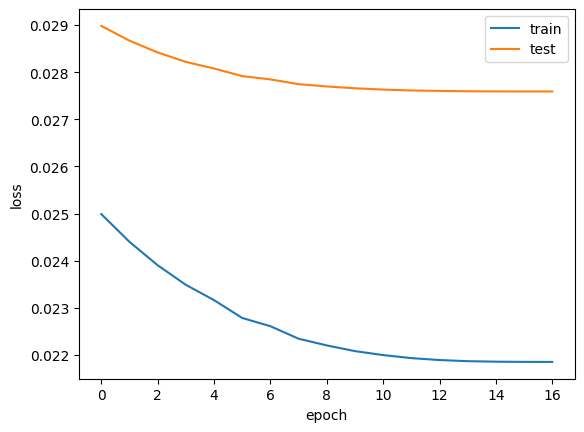

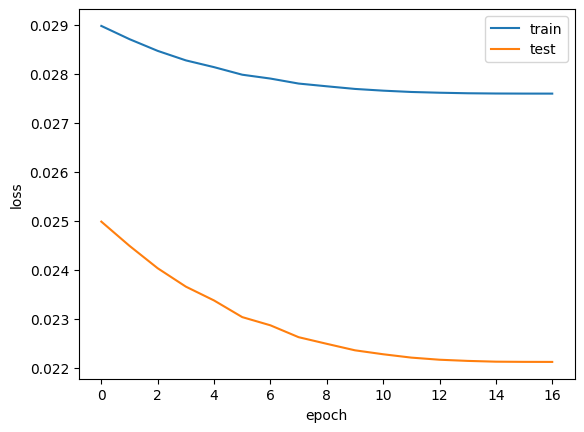

In [3]:
from fsrs_optimizer import Trainer, lineToTensor, StratifiedGroupKFold
import numpy as np

lr: float = 1e-4
n_epoch: int = 16
n_splits: int = 2
batch_size: int = 4096
verbose: bool = True

dataset = optimizer.dataset
dataset["tensor"] = dataset.progress_apply(
    lambda x: lineToTensor(list(zip([x["t_history"]], [x["r_history"]]))[0]),
    axis=1,
)
dataset["group"] = dataset["r_history"] + dataset["t_history"]

w = []
plots = []
sgkf = StratifiedGroupKFold(n_splits=n_splits)
for train_index, test_index in sgkf.split(dataset, dataset["i"], dataset["group"]):
    train_set = dataset.iloc[train_index].copy()
    test_set = dataset.iloc[test_index].copy()
    trainer = Trainer(
        train_set,
        test_set,
        optimizer.init_w,
        n_epoch=n_epoch,
        lr=lr,
        batch_size=batch_size,
    )
    trainer.loss_fn = ICILoss()
    w.append(trainer.train(verbose=verbose))
    if verbose:
        plots.append(trainer.plot())

w = np.array(w)
avg_w = np.round(np.mean(w, axis=0), 4)
optimizer.w = avg_w.tolist()

Loss before training: 0.4219
Loss after training: 0.4206
R-squared: 0.8518
RMSE: 0.0341
MAE: 0.0256
ICI: 0.0240
E50: 0.0183
E90: 0.0414
EMax: 0.2929
[0.20073657 0.75175466]

Last rating: 1
R-squared: 0.4834
RMSE: 0.0629
MAE: 0.0578
ICI: 0.0563
E50: 0.0627
E90: 0.0843
EMax: 0.2016
[0.24511055 0.6601604 ]

Last rating: 2
R-squared: 0.7455
RMSE: 0.0451
MAE: 0.0405
ICI: 0.0379
E50: 0.0369
E90: 0.0436
EMax: 0.2992
[0.15866013 0.77663394]

Last rating: 3
R-squared: 0.8503
RMSE: 0.0333
MAE: 0.0208
ICI: 0.0192
E50: 0.0114
E90: 0.0358
EMax: 0.2791
[0.22202032 0.74555013]

Last rating: 4
R-squared: -2.5972
RMSE: 0.0599
MAE: 0.0361
ICI: 0.0356
E50: 0.0252
E90: 0.0791
EMax: 0.3810
[0.63147401 0.36364122]


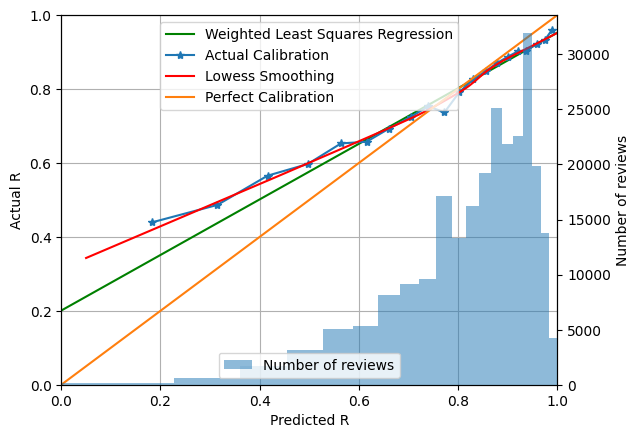

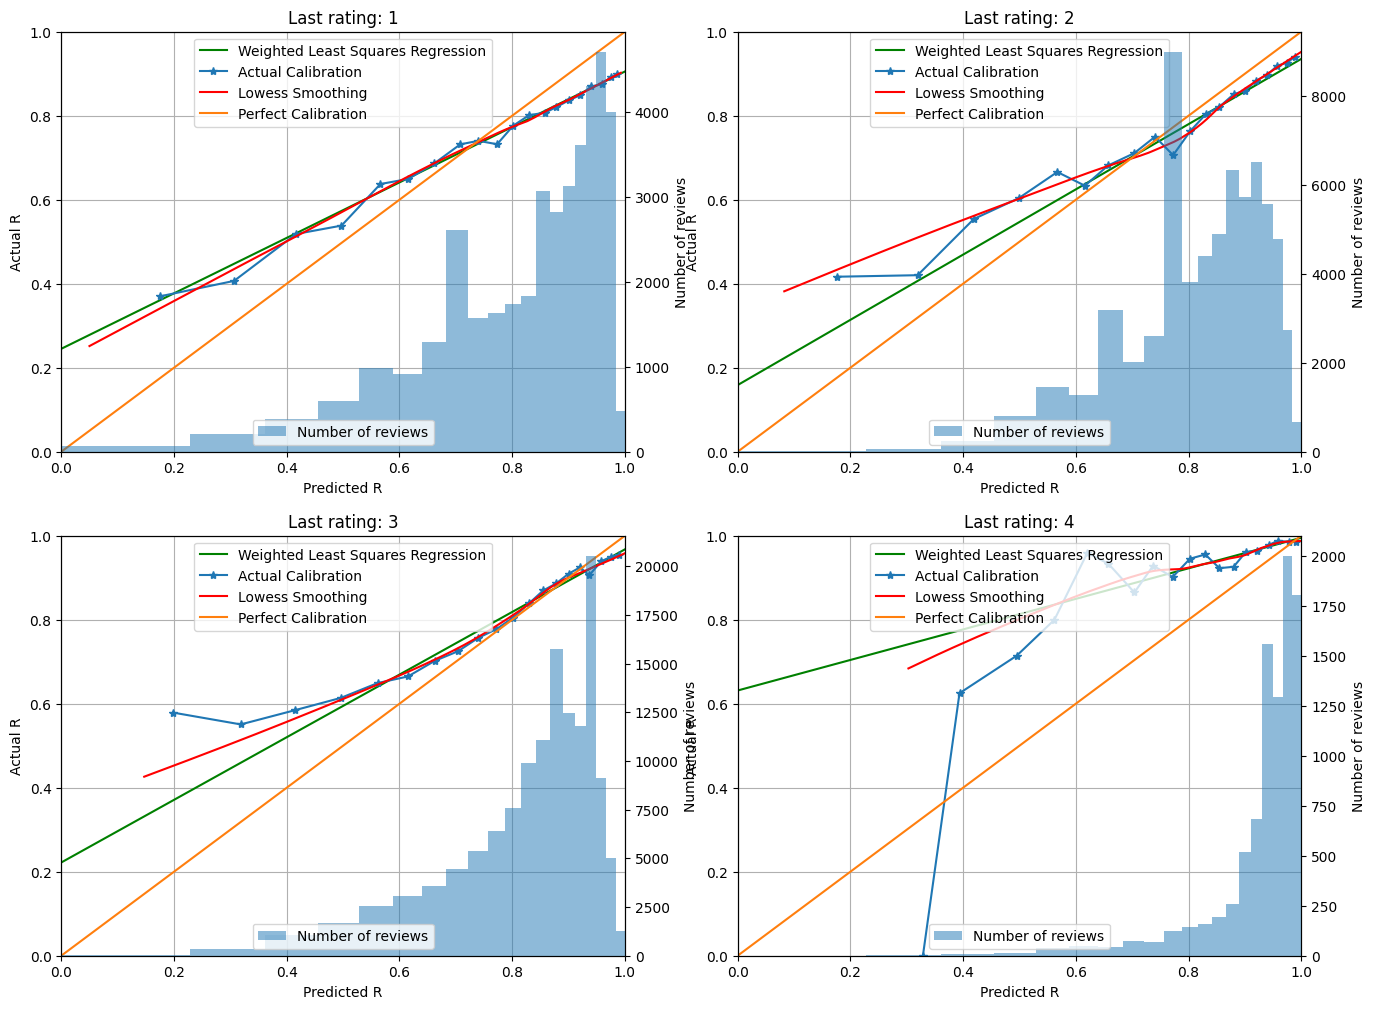

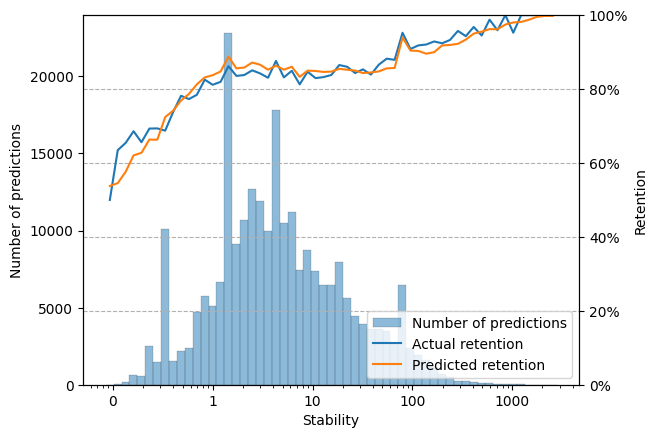

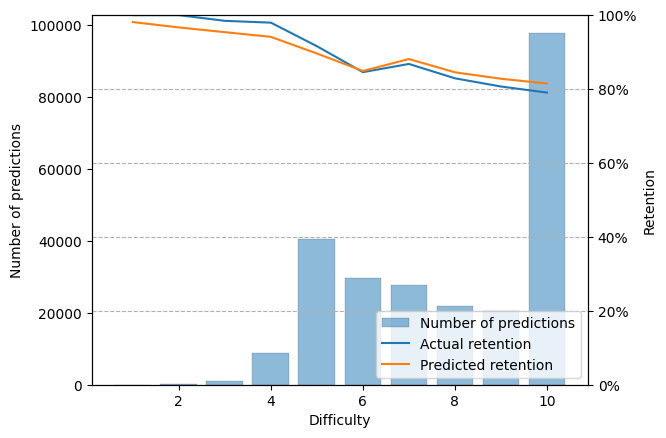

In [4]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")
metrics, figures = optimizer.calibration_graph()